<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-LDPC-ALIST" data-toc-modified-id="Load-LDPC-ALIST-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load LDPC ALIST</a></span></li><li><span><a href="#Test-LDPC-encoder" data-toc-modified-id="Test-LDPC-encoder-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test LDPC encoder</a></span></li></ul></div>

<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_fec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.comm.metrics import signal_power, calcLLR, fastBERcalc
from optic.dsp.core import pnorm
from optic.comm.fec import par2gen, encodeLDPC, decodeLDPC, encoder, readAlist
from optic.models.channels import awgn
from optic.plot import pconst
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import io
from scipy.sparse import csr_matrix, csc_matrix
from tqdm.notebook import tqdm
from numba import njit

import os.path as path
import time

In [3]:
%load_ext autoreload
%autoreload 2

In [21]:
def plot_matrix(H):
    """
    Plot the LDPC parity-check matrix H with blue dots at positions where H[i,j] = 1.

    Parameters
    ----------
    H : ndarray of shape (m, n)
        Binary parity-check matrix.
    """
    H = np.asarray(H)
    rows, cols = np.where(H == 1)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(cols, rows, s=0.05, color='blue')  # s controls dot size
    plt.gca().invert_yaxis()
    plt.xlabel('Column index (Variable nodes)')
    plt.ylabel('Row index (Check nodes)')
    plt.title('LDPC Parity-Check Matrix')
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
def ldpc_encode_systematic(H, u):
    """
    Encode a message using systematic LDPC encoding (DVB-S2 style).
    
    Parameters
    ----------
    H : ndarray of shape (m, n)
        Full LDPC parity-check matrix, assumed to be in the form [H1 | H2].

    u : ndarray of shape (k,)
        Binary input message bits to encode.

    Returns
    -------
    codeword : ndarray of shape (n,)
        Encoded codeword (information bits + parity bits).
    """
    m, n = H.shape
    k = n - m

    H1 = H[:, :k]
    H2 = H[:, k:]

    # Check if H2 is invertible (over GF(2))
    H2_inv = gf2_inverse(H2)

    if H2_inv is None:
        raise ValueError("H2 is not invertible over GF(2).")

    rhs = H1 @ u % 2
    p = H2_inv @ rhs % 2
    codeword = np.concatenate([u, p])
    return codeword.astype(np.uint8)

def gf2_inverse(A):
    """
    Compute the inverse of a binary matrix over GF(2) using Gauss-Jordan elimination.

    Parameters
    ----------
    A : ndarray of shape (n, n)
        Binary square matrix.

    Returns
    -------
    A_inv : ndarray or None
        Inverse of A over GF(2), or None if not invertible.
    """
    A = A.copy().astype(np.uint8)
    n = A.shape[0]
    I = np.eye(n, dtype=np.uint8)
    AI = np.concatenate((A, I), axis=1)

    for i in range(n):
        # Find a pivot row
        if AI[i, i] == 0:
            for j in range(i+1, n):
                if AI[j, i] == 1:
                    AI[[i, j]] = AI[[j, i]]
                    break
            else:
                return None  # Not invertible

        # Eliminate column
        for j in range(n):
            if j != i and AI[j, i] == 1:
                AI[j] ^= AI[i]

    return AI[:, n:]

## Load LDPC ALIST

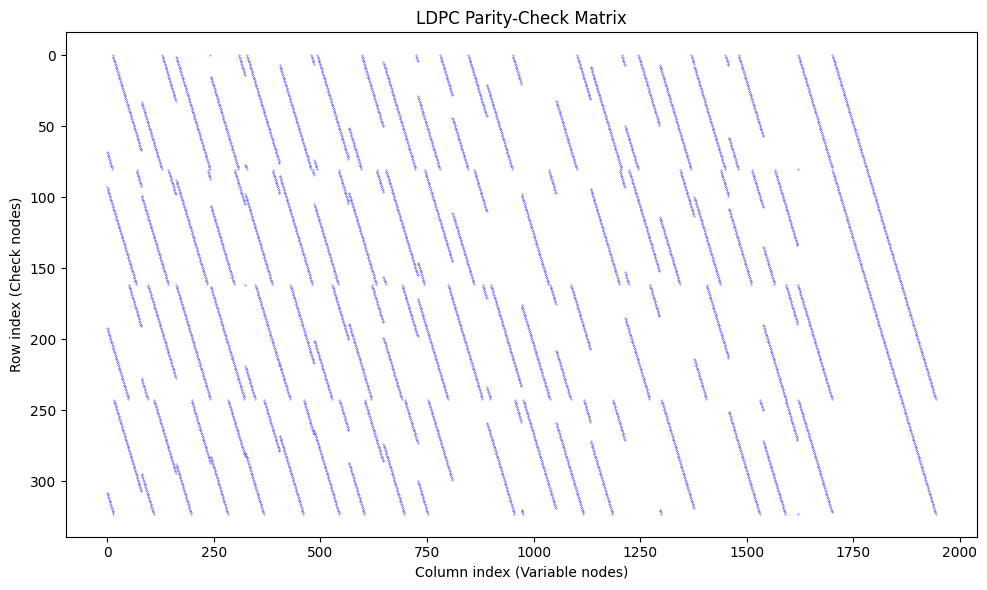

In [24]:
alistFolder = r'C:\Users\edson\OneDrive\Documentos\GitHub\OptiCommPy-private\optic\comm\ALIST'
filename = r'\LDPC_11nD2_1944b_R56.txt'
#filename = r'\LDPC_AR4JA_5120b_R45.txt'

H = readAlist(alistFolder+filename)
plot_matrix(csr_matrix.todense(H).astype(np.int8))

In [6]:
# #pathdir = r'C:\Users\edson.DESKTOP-54IJM4F\Documents\GitHub\robochameleon-private\addons\AR4JA_LDPC_FEC'
# #pathdir = r'C:\Users\edson.DESKTOP-54IJM4F\Documents\GitHub\robochameleon-private\addons\IEEE_802_11n_LDPC_FEC'
# #pathdir = r'C:\Users\edson\OneDrive\Documentos\GitHub\robochameleon-private\addons\IEEE_802_11n_LDPC_FEC'
# pathdir = r'C:\Users\edson\OneDrive\Documentos\GitHub\robochameleon-private\addons\AR4JA_LDPC_FEC'

# d = sp.io.loadmat(pathdir+'\LDPC_AR4JA_20480b_R45.mat')
# #d = sp.io.loadmat(pathdir+'\LDPC_11nD2_648b_R56.mat')
# #d = sp.io.loadmat('LDPC_AR4JA_1280b_R45.mat')
# H = csr_matrix(d['H'])

# #H = d['LDPC']['H'] # parity check matrix
# #H = H[0][0][0][0][0]
# #H = sp.sparse.csr_matrix.todense(H).astype(np.int8)
# #H = sp.sparse.csr_matrix(H)
# #H = np.asarray(H)

# # file_path = r'C:\Users\edson.DESKTOP-54IJM4F\Documents\GitHub\OptiCommPy-private\optic\fecParams\LDPC_ARJA_1280b_R45.txt'

# # ldpc.write_ldpc_params(H, file_path)

In [7]:
# from pathlib import Path

# pathdir = r'C:\Users\edson\OneDrive\Documentos\GitHub\robochameleon-private\addons\IEEE_802_11n_LDPC_FEC'
# #pathdir = r'C:\Users\edson\OneDrive\Documentos\GitHub\robochameleon-private\addons\AR4JA_LDPC_FEC'

# alistFolder = r'C:\Users\edson\OneDrive\Documentos\GitHub\OptiCommPy-private\optic\comm\ALIST\\'

# # Specific directory
# mat_files = list(Path(pathdir).glob('*.mat'))

# # Convert Path objects to strings if needed
# mat_files = [str(file) for file in mat_files]

# for file in mat_files:
#     d = sp.io.loadmat(file)
#     #H = csr_matrix(d['H'])
#     H = d['LDPC']['H'] # parity check matrix
#     H = H[0][0][0][0][0]
#     H = sp.sparse.csr_matrix(H)
#     filename = alistFolder + file[93:-4] + '.txt'
#     print(filename)
#     write_alist(csr_matrix.todense(H).astype(np.int8).astype(np.int8), filename)    

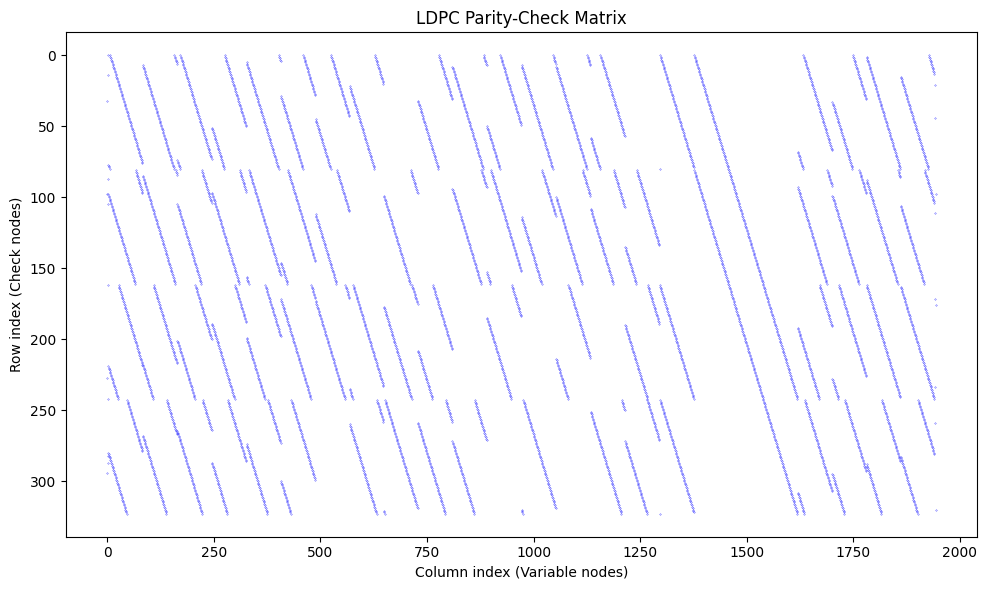

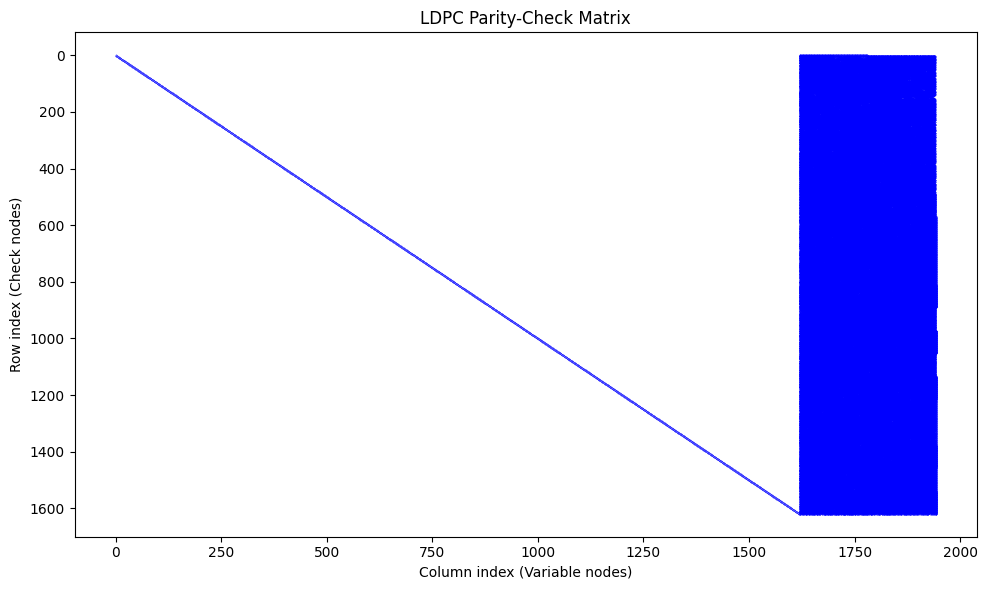

In [26]:
G, colSwaps, Hnew = par2gen(H)

revertColSwaps = np.argsort(colSwaps)
plot_matrix(csr_matrix.todense(H).astype(np.int8)[:,colSwaps])
plot_matrix(G)

In [9]:
# plt.imshow(csr_matrix.todense(H).astype(np.int8));
# plt.title('Parity check matrix - H')
# plt.figure()
# plt.imshow(csr_matrix.todense(H[:,colSwaps]).astype(np.int8));
# plt.title('Parity check matrix - H')
# plt.figure()
# plt.imshow(Hnew);
# plt.title('New parity check matrix - H')
# plt.figure()
# plt.imshow(G);
# plt.title('Generator matrix - G')

In [15]:
print('H :', H.shape)
print('G :', G.shape)
print('n = ', H.shape[1])
print('k = ', G.shape[0])
print('R = ', round(G.shape[0]/G.shape[1],2))

H : (12960, 64800)
G : (51840, 64800)
n =  64800
k =  51840
R =  0.8


## Test LDPC encoder

In [28]:
Nwords = 10

# generate random bits
bits = np.random.randint(2, size = (G.shape[0], Nwords), dtype=np.uint8)

start = time.time()
codedbits = encodeLDPC(H, bits, G)
end = time.time()
print(f'Time for encoding per codeword: {(end-start)/Nwords:.2f} s')
np.mod(H[:,colSwaps]@codedbits,2)

Time for encoding per codeword: 0.00 s


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Time for encoding: 0.99 s


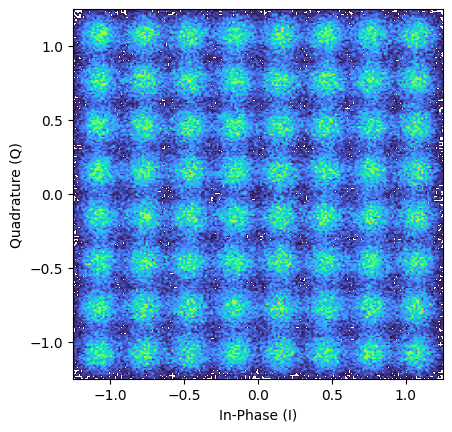

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:12<00:00, 64.27it/s]

Time for decoding: 12.60 s
BERpreFEC = 2.15e-02
BERpostFEC = 0.00e+00
Number of bits =  1555200


In [31]:
# Run AWGN simulation 
EbN0dB = 10.5
M      = 64
Nwords = 800
nIter  = 50

# modulation parameters
constSymb = grayMapping(M,'qam')             # constellation
bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
bitMap = bitMap.reshape(-1, int(np.log2(M)))
Es = signal_power(constSymb)                 # mean symbol energy

# generate random bits
bits = np.random.randint(2, size = (G.shape[0], Nwords),  dtype=np.uint8)

# encode data bits with LDPC soft-FEC
start = time.time()
codedBits = encodeLDPC(H, bits, G)
end = time.time()
print(f'Time for encoding: {end-start:.2f} s')

codedBitsTx = codedBits.copy().flatten()

# Map bits to constellation symbols
symbTx = modulateGray(codedBitsTx, M, 'qam')

# Normalize symbols energy to 1
symbTx = pnorm(symbTx)

# AWGN    
snrdB  = EbN0dB + 10*np.log10(np.log2(M))
symbRx = awgn(symbTx, snrdB)

# pre-FEC BER calculation (hard demodulation)
BERpre, _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
pconst(symbRx, pType='fancy')

# soft-demodulation
noiseVar = 1/10**(snrdB/10)
px = np.ones(M)/M
llr = calcLLR(pnorm(symbRx), noiseVar, pnorm(constSymb), bitMap, px)

start = time.time()
decodedBits, llr_dec = decodeLDPC(llr.reshape(-1,codedBits.shape[1]).T, H[:,colSwaps], nIter, alg='MSA', prgsBar=True, prec=np.float16)
end = time.time()
print(f'Time for decoding: {end-start:.2f} s')
decodedBits = (decodedBits.T).flatten()

# post-FEC BER calculation
BERpost = np.mean(np.logical_xor(codedBitsTx.flatten(), decodedBits.flatten()))

print('BERpreFEC = %.2e'%BERpre[0])
print('BERpostFEC = %.2e'%BERpost)
print('Number of bits = ', decodedBits.size)

In [33]:
Nwords = 600
nIter  = 50

# Run BER vs Ebn0 Monte Carlo simulation 
qamOrder  = [64]  # Modulation order
EbN0dB_  = np.arange(9.5, 11.55, 0.05)

BERpre   = np.zeros((len(EbN0dB_),len(qamOrder)))
BERpost  = np.zeros((len(EbN0dB_),len(qamOrder)))

BERpre[:]  = np.nan
BERpost[:] = np.nan

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)

    # modulation parameters
    constSymb = grayMapping(M,'qam')             # constellation
    bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
    bitMap = bitMap.reshape(-1, int(np.log2(M)))
    
    for indSNR in tqdm(range(EbN0dB_.size)):

        EbN0dB = EbN0dB_[indSNR]

        # generate random bits
        bits = np.random.randint(2, size = (G.shape[0], Nwords))

        # encode data bits with LDPC soft-FEC
        codedBits = encodeLDPC(H, bits, G)
        codedBitsTx = codedBits.copy().flatten()

        # Map bits to constellation symbols
        symbTx = modulateGray(codedBitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = pnorm(symbTx)

        # AWGN    
        snrdB  = EbN0dB + 10*np.log10(np.log2(M))
        symbRx = awgn(symbTx, snrdB)

        # pre-FEC BER calculation (hard demodulation)
        BERpre[indSNR, ii], _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
       
        # soft-demodulation
        noiseVar = 1/10**(snrdB/10)
        px = np.ones(M)/M
        llr = calcLLR(pnorm(symbRx), noiseVar, pnorm(constSymb), bitMap, px)

        decodedBits, llr_dec = decodeLDPC(llr.reshape(-1,codedBits.shape[1]).T, H[:,colSwaps], nIter, alg='MSA', prgsBar=False, prec=np.float16)
        decodedBits = (decodedBits.T).flatten()

        # post-FEC BER calculation
        BERpost[indSNR, ii] = np.mean(np.logical_xor(codedBitsTx.flatten(), decodedBits.flatten()))        

run sim: M =  64


  0%|          | 0/40 [00:00<?, ?it/s]

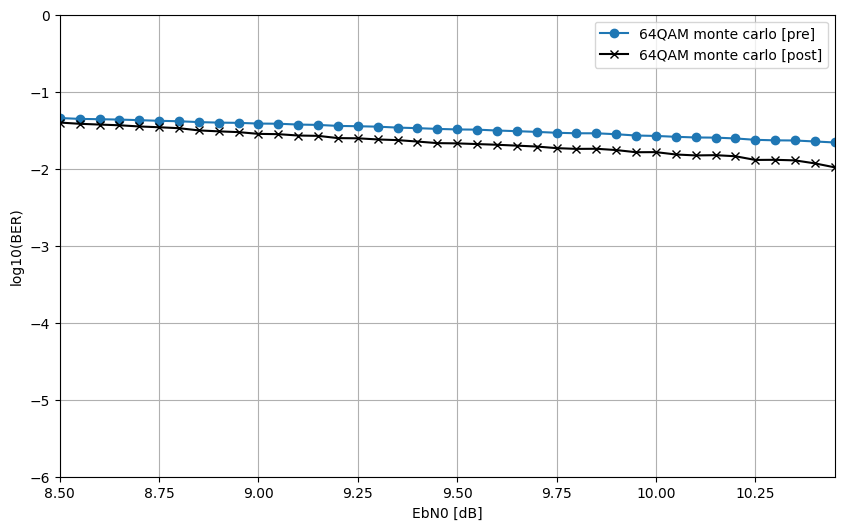

In [34]:
# Plot simulation results       
BERpre[BERpre==0] = np.nan
BERpost[BERpost==0] = np.nan

plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(
        EbN0dB_,
        np.log10(BERpre[:, ii]),
        'o-',
        label=f'{str(M)}QAM monte carlo [pre]',
    )


#plt.gca().set_prop_cycle(None)

for ii, M in enumerate(qamOrder):
    plt.plot(
        EbN0dB_,
        np.log10(BERpost[:, ii]),
        'kx-',
        label=f'{str(M)}QAM monte carlo [post]',
    )


plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]');
plt.ylabel('log10(BER)');
plt.grid()